# Table of Contents 

* [Imports & Functions](#imports-and-functions)
* [Unrestricted Models](#unrestricted-models)
    * [Stacked Regressor](#stacked-reg-unrestricted)
    * [Regression-Enhanced Random Forest](#rerf-unrestricted)
* [Restricted Models](#restricted-models)
    * [Stacked Regressor](#stacked-reg-restricted)
    * [Regression-Enhanced Random Forest](#rerf-restricted)

# Imports & Functions <a class="anchor" id="imports-and-functions"></a>

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import matplotlib.dates as mdates

/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def custom_mape(actual, forecast, epsilon=1e-10):
    """
    Custom MAPE calculation that handles zero and near-zero values.
    
    Parameters:
    - actual: array-like, actual values
    - forecast: array-like, forecasted values
    - epsilon: small constant to replace zero values
    
    Returns:
    - mape: Mean Absolute Percentage Error
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Replace zero values in actual with epsilon to avoid division by zero
    actual = np.where(actual == 0, epsilon, actual)
    
    return np.mean(np.abs((actual - forecast) / actual)) * 100


def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

In [3]:
#Reading in training data 
X_train_front = pd.read_csv('X_train_front_log_transformed.csv')
y_train_front = pd.read_csv('y_train_front_log_transformed.csv')
X_train_second = pd.read_csv('X_train_second_log_transformed.csv')
y_train_second = pd.read_csv('y_train_second_log_transformed.csv')

In [4]:
#Reading in test data 
X_test_front = pd.read_csv('X_test_front_log_transformed.csv')
y_test_front = pd.read_csv('y_test_front_log_transformed.csv')
X_test_second = pd.read_csv('X_test_second_log_transformed.csv')
y_test_second = pd.read_csv('y_test_second_log_transformed.csv')

In [5]:
#Setting indices of X and y datasets

X_train_front.set_index('Date', inplace=True)
y_train_front.set_index('Date', inplace=True)
X_train_second.set_index('Date', inplace=True)
y_train_second.set_index('Date', inplace=True)

X_test_front.set_index('Date', inplace=True)
y_test_front.set_index('Date', inplace=True)
X_test_second.set_index('Date',inplace=True)
y_test_second.set_index('Date',inplace=True)

In [6]:
#Copies of y datasets for plot-referencing
y_train_front_idx = y_train_front.copy()
y_test_front_idx = y_test_front.copy()

y_train_second_idx = y_train_second.copy()
y_test_second_idx = y_test_second.copy()

In [7]:
#Converting target df into 1-D array
y_train_front = y_train_front.values.ravel()
y_test_front = y_test_front.values.ravel()

y_train_second = y_train_second.values.ravel()
y_test_second = y_test_second.values.ravel()

# Unrestricted Models <a class="anchor" id="unrestricted-models"></a>

In [8]:
#Reading-in JSON file
with open('front_month_selected_features.json', 'r') as f:
    front_month_selected_features = json.load(f)

In [9]:
#Reading-in JSON file
with open('second_month_selected_features.json', 'r') as f:
    second_month_selected_features = json.load(f)

## Stacked Regressor <a class="anchor" id="stacked-reg-unrestricted"></a>

### Front-month

In [10]:
front_month_selected_features

['HIGH_x_log',
 'Year',
 'LOW_x_log',
 'Month',
 'OPEN_x_log',
 'CLOSE_y_log',
 'HIGH_y_log',
 'stocks_daily_log']

In [11]:
#Creating new training X 
X_train_front_selected_features = X_train_front[front_month_selected_features]
X_test_front_selected_features = X_test_front[front_month_selected_features]

In [12]:
#Setting a global seed
np.random.seed(42)

#Defining base models
base_models = [
    ('mlr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# Define the stacked regressor
stacked_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge() #Ridge as final estimator
)

#Fitting the stacked regressor on the training data
stacked_regressor.fit(X_train_front_selected_features, y_train_front)

#Pre-tune train eval 
y_pred_train_front_base = stacked_regressor.predict(X_train_front_selected_features)

train_base_stacked_reg_mae_front = mean_absolute_error(y_train_front, y_pred_train_front_base)
train_base_stacked_reg_rmse_front = np.sqrt(mean_squared_error(y_train_front, y_pred_train_front_base))
train_base_stacked_reg_mape_front = custom_mape(y_train_front, y_pred_train_front_base)
train_base_stacked_reg_r2_front = r2_score(y_train_front, y_pred_train_front_base)
train_base_stacked_reg_adj_r2_front = adjusted_r2(train_base_stacked_reg_r2_front, len(y_train_front), X_train_front_selected_features.shape[1])


y_pred_front_base = stacked_regressor.predict(X_test_front_selected_features)

#Pre-tune test eval
base_stacked_reg_mae_front = mean_absolute_error(y_test_front, y_pred_front_base)
base_stacked_reg_rmse_front = np.sqrt(mean_squared_error(y_test_front, y_pred_front_base))
base_stacked_reg_mape_front = custom_mape(y_test_front, y_pred_front_base)
base_stacked_reg_r2_front = r2_score(y_test_front, y_pred_front_base)
base_stacked_reg_adj_r2_front = adjusted_r2(base_stacked_reg_r2_front, len(y_test_front), X_test_front_selected_features.shape[1])


print(f'Pre-Tuning Training Mean Absolute Error (MAE): {train_base_stacked_reg_mae_front}')
print(f'Pre-Tuning Training Root Mean Squared Error (RMSE): {train_base_stacked_reg_rmse_front}')
print(f'Pre-Tuning Training Mean Absolute Percentage Error (MAPE): {train_base_stacked_reg_mape_front}%')
print(f'Pre-Tuning Training R-squared: {train_base_stacked_reg_r2_front}')

#Defining a hyperparameter grid for the base models and final estimator
param_grid = {
    'mlr__fit_intercept': [True, False],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'final_estimator__alpha': [0.01, 0.1, 1.0],  # Ridge regularization parameter
    'final_estimator__fit_intercept': [True, False]
}

#Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#Grid search with cross-validation
grid_search = GridSearchCV(stacked_regressor, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_front_selected_features, y_train_front)

best_params_front = grid_search.best_params_
best_model_front = grid_search.best_estimator_

#Fitting best-params model
best_model_front.fit(X_train_front_selected_features, y_train_front)

#Post-tune train prediction
y_pred_train_front = best_model_front.predict(X_train_front_selected_features)

#Post-tune train eval
train_stacked_reg_mae_front = mean_absolute_error(y_train_front, y_pred_train_front)
train_stacked_reg_rmse_front = np.sqrt(mean_squared_error(y_train_front, y_pred_train_front))
train_stacked_reg_mape_front = custom_mape(y_train_front, y_pred_train_front)
train_stacked_reg_r2_front = r2_score(y_train_front, y_pred_train_front)
train_stacked_reg_adj_r2_front = adjusted_r2(train_stacked_reg_r2_front, len(y_train_front), X_train_front_selected_features.shape[1])


print(f'Post-Tuning Training Mean Absolute Error (MAE): {train_stacked_reg_mae_front}')
print(f'Post-Tuning Training Root Mean Squared Error (RMSE): {train_stacked_reg_rmse_front}')
print(f'Post-Tuning Training Mean Absolute Percentage Error (MAPE): {train_stacked_reg_mape_front}%')
print(f'Post-Tuning Training R-squared: {train_stacked_reg_r2_front}')

#Post-tune test prediction
y_pred_front = best_model_front.predict(X_test_front_selected_features)

#Post-tune test eval
stacked_reg_mae_front = mean_absolute_error(y_test_front, y_pred_front)
stacked_reg_rmse_front = np.sqrt(mean_squared_error(y_test_front, y_pred_front))
stacked_reg_mape_front = custom_mape(y_test_front, y_pred_front)
stacked_reg_r2_front = r2_score(y_test_front, y_pred_front)
stacked_reg_adj_r2_front = adjusted_r2(stacked_reg_r2_front, len(y_test_front), X_test_front_selected_features.shape[1])


print(f'Test Mean Absolute Error (MAE): {stacked_reg_mae_front}')
print(f'Test Root Mean Squared Error (RMSE): {stacked_reg_rmse_front}')
print(f'Test Mean Absolute Percentage Error (MAPE): {stacked_reg_mape_front}%')
print(f'Test R-squared: {stacked_reg_r2_front}')

Pre-Tuning Training Mean Absolute Error (MAE): 0.011579174697315557
Pre-Tuning Training Root Mean Squared Error (RMSE): 0.01835816645806425
Pre-Tuning Training Mean Absolute Percentage Error (MAPE): 0.26325877258243874%
Pre-Tuning Training R-squared: 0.9977487462374575


/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.

Post-Tuning Training Mean Absolute Error (MAE): 0.012175097573722789
Post-Tuning Training Root Mean Squared Error (RMSE): 0.019285590684923925
Post-Tuning Training Mean Absolute Percentage Error (MAPE): 0.2768566178367505%
Post-Tuning Training R-squared: 0.9975155415667022
Test Mean Absolute Error (MAE): 0.009339330096254941
Test Root Mean Squared Error (RMSE): 0.013902953191473458
Test Mean Absolute Percentage Error (MAPE): 0.1983069621195673%
Test R-squared: 0.9763754460560841


In [13]:
#Converting metrics to original scale
train_base_stacked_reg_mae_front = np.exp(train_base_stacked_reg_mae_front) - 1
train_base_stacked_reg_rmse_front = np.exp(train_base_stacked_reg_rmse_front) - 1
train_stacked_reg_mae_front = np.exp(train_stacked_reg_mae_front) - 1
train_stacked_reg_rmse_front = np.exp(train_stacked_reg_rmse_front) - 1


base_stacked_reg_mae_front = np.exp(base_stacked_reg_mae_front) - 1
base_stacked_reg_rmse_front = np.exp(base_stacked_reg_rmse_front) - 1
stacked_reg_mae_front = np.exp(stacked_reg_mae_front) - 1
stacked_reg_rmse_front = np.exp(stacked_reg_rmse_front) - 1


#Storing results in dict objects
train_stacked_regressor_base_results_front_dict = {
    'Model': 'Stacked Regressor',
    'MAE': train_base_stacked_reg_mae_front,
    'RMSE': train_base_stacked_reg_rmse_front,
    'MAPE': train_base_stacked_reg_mape_front,
    'R-squared': train_base_stacked_reg_r2_front,
    'Adjusted R-squared': train_base_stacked_reg_adj_r2_front
}

#Storing post-tuning evaluation metrics 
train_stacked_regressor_results_front_dict = {
    'Model': 'Stacked Regressor',
    'MAE': train_stacked_reg_mae_front,
    'RMSE': train_stacked_reg_rmse_front,
    'MAPE': train_stacked_reg_mape_front,
    'R-squared': train_stacked_reg_r2_front,
    'Adjusted R-squared': train_stacked_reg_adj_r2_front
}



stacked_regressor_base_results_front_dict = {
    'Model': 'Stacked Regressor',
    'MAE': base_stacked_reg_mae_front,
    'RMSE': base_stacked_reg_rmse_front,
    'MAPE': base_stacked_reg_mape_front,
    'R-squared': base_stacked_reg_r2_front, 
    'Adjusted R-squared': base_stacked_reg_adj_r2_front
}


#Storing post-tuning evaluation metrics 
stacked_regressor_results_front_dict = {
    'Model': 'Stacked Regressor',
    'MAE': stacked_reg_mae_front,
    'RMSE': stacked_reg_rmse_front,
    'MAPE': stacked_reg_mape_front,
    'R-squared': stacked_reg_r2_front, 
    'Adjusted R-squared': stacked_reg_adj_r2_front
}


#Converting to dfs
train_stacked_reg_front_base_results = pd.DataFrame([train_stacked_regressor_base_results_front_dict])
train_stacked_reg_front_results = pd.DataFrame([train_stacked_regressor_results_front_dict])


stacked_reg_front_base_results = pd.DataFrame([stacked_regressor_base_results_front_dict])
stacked_reg_front_results = pd.DataFrame([stacked_regressor_results_front_dict])

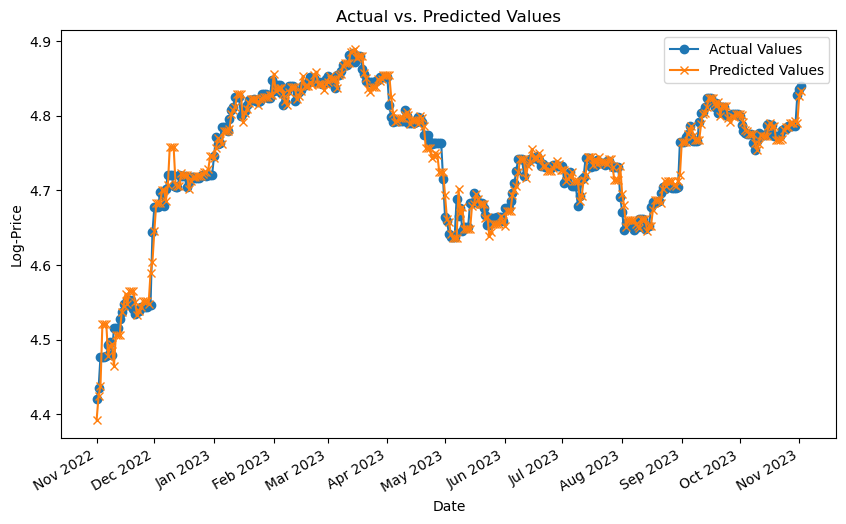

In [14]:
#Plotting actual versus predicted values

y_test_front_idx.index = pd.to_datetime(y_test_front_idx.index)

dates = y_test_front_idx.index
actual_values = y_test_front_idx['CLOSE_x']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_values, label='Actual Values', marker='o')
plt.plot(dates, y_pred_front, label='Predicted Values', marker='x')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.xlabel('Date')
plt.ylabel('Log-Price')
plt.title('Actual vs. Predicted Values')
plt.legend()  

plt.gcf().autofmt_xdate()

plt.show()

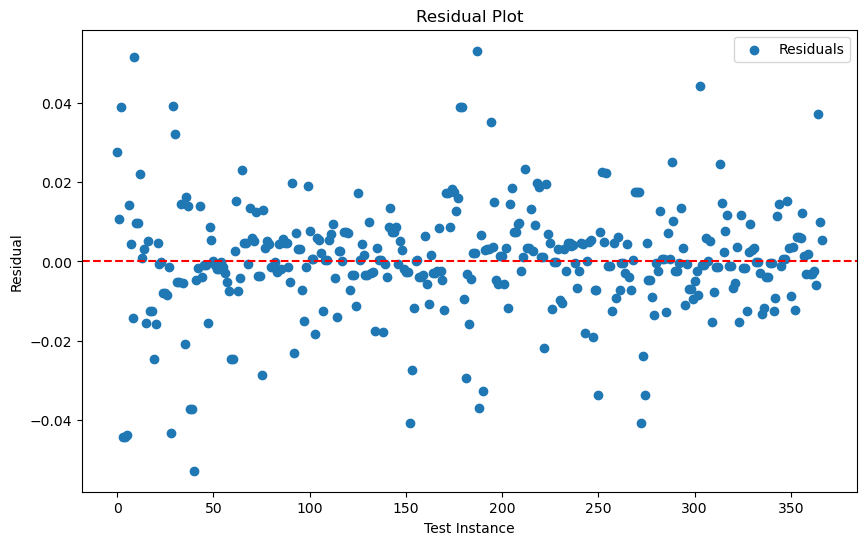

In [15]:
#Plotting residuals 

residuals_front = y_test_front - y_pred_front

#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_front)), residuals_front, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Test Instance')
plt.ylabel('Residual')
plt.legend()
plt.show()

The residuals are scattered randomly around the horizontal axis (residual = 0), which suggests that the model fits the data well. There appear to be no significant outliers that stand out far away from the bulk of the residuals.

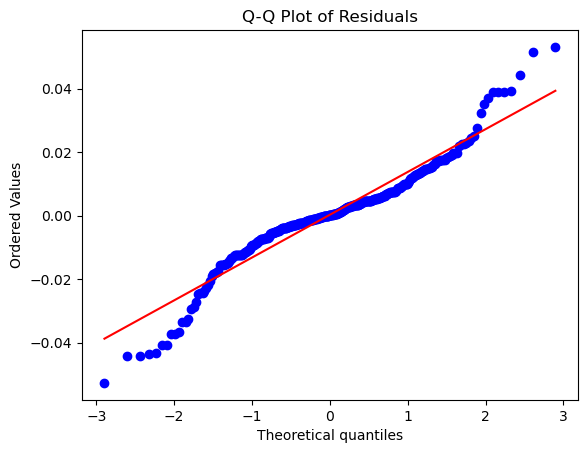

In [16]:
stats.probplot(residuals_front, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The majority of the residuals fall along the red line, which indicates that the residuals are approximately normally distributed. This suggests that the assumption of normality for the residuals is largely met.

### Second-month

The training and evaluation of the Stacked regressor is repeated for second-month dataset

In [17]:
#Creating new training X 
X_train_second_selected_features = X_train_second[second_month_selected_features]
X_test_second_selected_features = X_test_second[second_month_selected_features]

In [18]:
np.random.seed(42)

#Defining base models
base_models = [
    ('mlr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

#Defining the stacked regressor
stacked_regressor_second = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge()
)

#Fitting on the training data
stacked_regressor_second.fit(X_train_second_selected_features, y_train_second)

#Pre-tune train prediction
y_pred_train_second_base = stacked_regressor_second.predict(X_train_second_selected_features)

#Pre-tune train eval
train_base_stacked_reg_mae_second = mean_absolute_error(y_train_second, y_pred_train_second_base)
train_base_stacked_reg_rmse_second = np.sqrt(mean_squared_error(y_train_second, y_pred_train_second_base))
train_base_stacked_reg_mape_second = custom_mape(y_train_second, y_pred_train_second_base)
train_base_stacked_reg_r2_second = r2_score(y_train_second, y_pred_train_second_base)
train_base_stacked_reg_adj_r2_second = adjusted_r2(train_base_stacked_reg_r2_second, len(y_train_second), X_train_second_selected_features.shape[1])

#Pre-tune test prediction
y_pred_second_base = stacked_regressor_second.predict(X_test_second_selected_features)

#Pre-tune test eval
base_stacked_reg_mae_second = mean_absolute_error(y_test_second, y_pred_second_base)
base_stacked_reg_rmse_second = np.sqrt(mean_squared_error(y_test_second, y_pred_second_base))
base_stacked_reg_mape_second = custom_mape(y_test_second, y_pred_second_base)
base_stacked_reg_r2_second = r2_score(y_test_second, y_pred_second_base)
base_stacked_reg_adj_r2_second = adjusted_r2(base_stacked_reg_r2_second, len(y_test_second), X_test_second_selected_features.shape[1])


# Defining a hyperparameter grid for the base models and final estimator
param_grid = {
    'mlr__fit_intercept': [True, False],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'final_estimator__alpha': [0.01, 0.1, 1.0],  # Ridge regularization parameter
    'final_estimator__fit_intercept': [True, False]
}

# Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#Grid search with cross-validation
grid_search = GridSearchCV(stacked_regressor_second, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_second_selected_features, y_train_second)

best_params_second = grid_search.best_params_
best_model_second = grid_search.best_estimator_

print(f"Best Parameters: {best_params_second}")

#Fitting the best params model 
best_model_second.fit(X_train_second_selected_features, y_train_second)

#Post-tune train prediction
y_pred_train_second = best_model_second.predict(X_train_second_selected_features)

#Post-tune train eval
train_stacked_reg_mae_second = mean_absolute_error(y_train_second, y_pred_train_second)
train_stacked_reg_rmse_second = np.sqrt(mean_squared_error(y_train_second, y_pred_train_second))
train_stacked_reg_mape_second = custom_mape(y_train_second, y_pred_train_second)
train_stacked_reg_r2_second = r2_score(y_train_second, y_pred_train_second)
train_stacked_reg_adj_r2_second = adjusted_r2(train_stacked_reg_r2_second, len(y_train_second), X_train_second_selected_features.shape[1])


print(f'Post-Tuning Training Mean Absolute Error (MAE): {train_stacked_reg_mae_second}')
print(f'Post-Tuning Training Root Mean Squared Error (RMSE): {train_stacked_reg_rmse_second}')
print(f'Post-Tuning Training Mean Absolute Percentage Error (MAPE): {train_stacked_reg_mape_second}%')
print(f'Post-Tuning Training R-squared: {train_stacked_reg_r2_second}')

#Post-tune test prediction
y_pred_second = best_model_second.predict(X_test_second_selected_features)

#Post-tune test eval
stacked_reg_mae_second = mean_absolute_error(y_test_second, y_pred_second)
stacked_reg_rmse_second = np.sqrt(mean_squared_error(y_test_second, y_pred_second))
stacked_reg_mape_second = custom_mape(y_test_second, y_pred_second)
stacked_reg_r2_second = r2_score(y_test_second, y_pred_second)
stacked_reg_adj_r2_second = adjusted_r2(stacked_reg_r2_second, len(y_test_second), X_test_second_selected_features.shape[1])

print(f'Test Mean Absolute Error (MAE): {stacked_reg_mae_second}')
print(f'Test Root Mean Squared Error (RMSE): {stacked_reg_rmse_second}')
print(f'Test Mean Absolute Percentage Error (MAPE): {stacked_reg_mape_second}%')
print(f'Test R-squared: {stacked_reg_r2_second}')

Best Parameters: {'final_estimator__alpha': 0.01, 'final_estimator__fit_intercept': True, 'mlr__fit_intercept': False, 'rf__max_depth': None, 'rf__n_estimators': 50}
Post-Tuning Training Mean Absolute Error (MAE): 0.01628089282471326
Post-Tuning Training Root Mean Squared Error (RMSE): 0.023802942095084646
Post-Tuning Training Mean Absolute Percentage Error (MAPE): 0.36912078422967376%
Post-Tuning Training R-squared: 0.9962541155144518
Test Mean Absolute Error (MAE): 0.013840306828600758
Test Root Mean Squared Error (RMSE): 0.018786216941091515
Test Mean Absolute Percentage Error (MAPE): 0.29373620083399%
Test R-squared: 0.9574889464551555


In [19]:
#Converting metrics to original scale
train_base_stacked_reg_mae_second = np.exp(train_base_stacked_reg_mae_second) - 1
train_base_stacked_reg_rmse_second = np.exp(train_base_stacked_reg_rmse_second) - 1
train_stacked_reg_mae_second = np.exp(train_stacked_reg_mae_second) - 1
train_stacked_reg_rmse_second = np.exp(train_stacked_reg_rmse_second) - 1


base_stacked_reg_mae_second = np.exp(base_stacked_reg_mae_second) - 1
base_stacked_reg_mae_second = np.exp(base_stacked_reg_mae_second) - 1
stacked_reg_mae_second = np.exp(stacked_reg_mae_second) - 1
stacked_reg_mae_second = np.exp(stacked_reg_mae_second) - 1

#Storing baseline evaluation metrics 
train_stacked_regressor_base_results_second_dict = {
    'Model': 'Stacked Regressor',
    'MAE': train_base_stacked_reg_mae_second,
    'RMSE': train_base_stacked_reg_rmse_second,
    'MAPE': train_base_stacked_reg_mape_second,
    'R-squared': train_base_stacked_reg_r2_second,
    'Adjusted R-squared': train_base_stacked_reg_adj_r2_second

}


stacked_regressor_base_results_second_dict = {
    'Model': 'Stacked Regressor',
    'MAE': base_stacked_reg_mae_second,
    'RMSE': base_stacked_reg_rmse_second,
    'MAPE': base_stacked_reg_mape_second,
    'R-squared': base_stacked_reg_r2_second, 
    'Adjusted R-squared': base_stacked_reg_adj_r2_second

}


#Storing post-tuning evaluation metrics 
train_stacked_regressor_results_second_dict = {
    'Model': 'Stacked Regressor',
    'MAE': train_stacked_reg_mae_second,
    'RMSE': train_stacked_reg_rmse_second,
    'MAPE': train_stacked_reg_mape_second,
    'R-squared': train_stacked_reg_r2_second, 
    'Adjusted R-squared': train_stacked_reg_adj_r2_second
}


stacked_regressor_results_second_dict = {
    'Model': 'Stacked Regressor',
    'MAE': stacked_reg_mae_second,
    'RMSE': stacked_reg_rmse_second,
    'MAPE': stacked_reg_mape_second,
    'R-squared': stacked_reg_r2_second, 
    'Adjusted R-squared': stacked_reg_adj_r2_second
}

#Converting to dfs
train_stacked_reg_second_base_results = pd.DataFrame([train_stacked_regressor_base_results_second_dict])
train_stacked_reg_second_results = pd.DataFrame([train_stacked_regressor_results_second_dict])


stacked_reg_second_base_results = pd.DataFrame([stacked_regressor_base_results_second_dict])
stacked_reg_second_results = pd.DataFrame([stacked_regressor_results_second_dict])

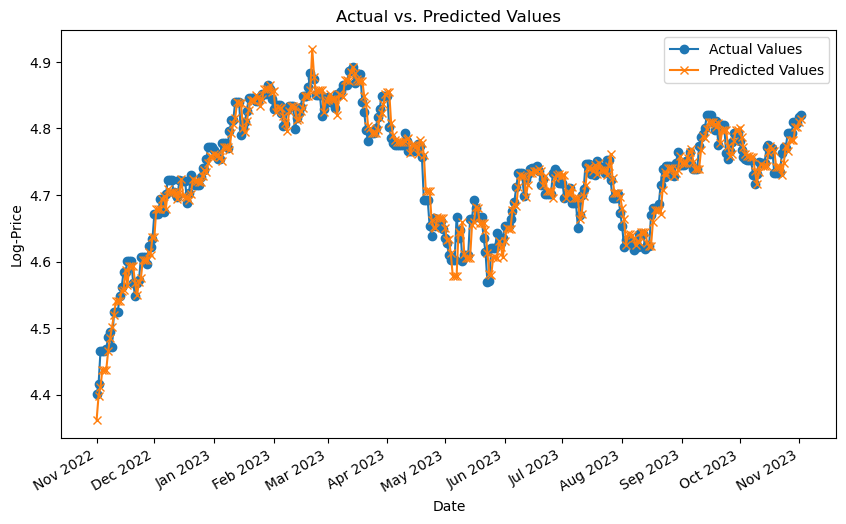

In [20]:
#Plotting 

y_test_second_idx.index = pd.to_datetime(y_test_second_idx.index)

dates = y_test_second_idx.index
actual_values = y_test_second_idx['CLOSE_y']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_values, label='Actual Values', marker='o')
plt.plot(dates, y_pred_second, label='Predicted Values', marker='x')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.xlabel('Date')
plt.ylabel('Log-Price')
plt.title('Actual vs. Predicted Values')
plt.legend()  

plt.gcf().autofmt_xdate()

plt.show()

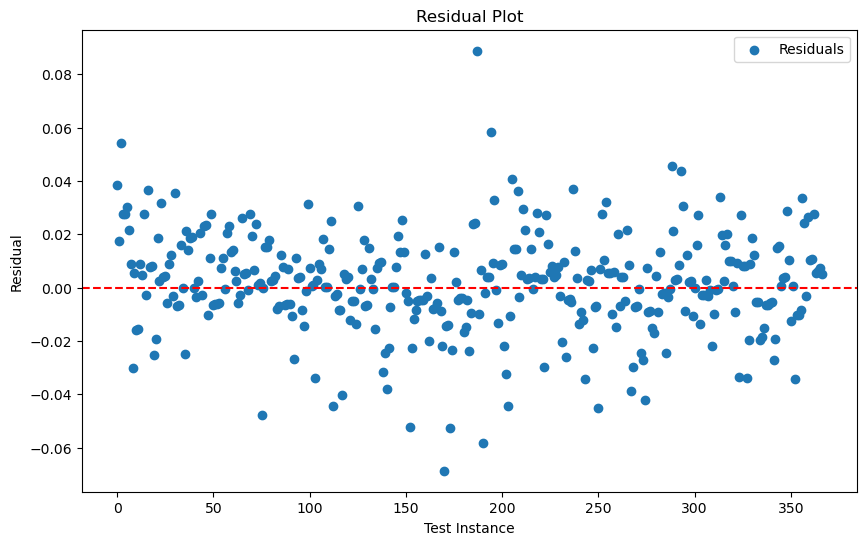

In [21]:
#Plotting residuals

residuals_second = y_test_second - y_pred_second

#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_second)), residuals_second, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Test Instance')
plt.ylabel('Residual')
plt.legend()
plt.show()

The spread of the residuals seems consistent across different test instances. This implies homoscedasticity, meaning the variance of the residuals is constant across all levels of the independent variable.

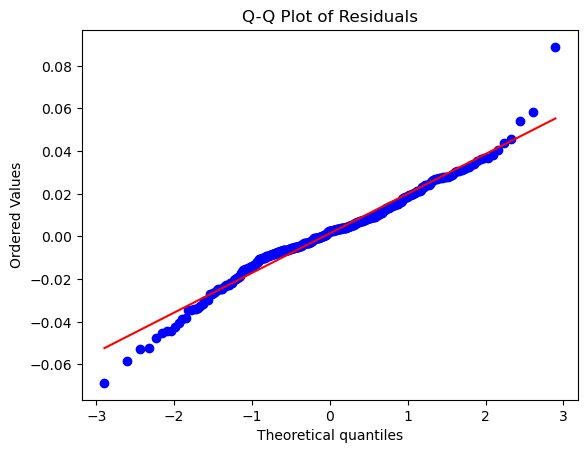

In [22]:
stats.probplot(residuals_second, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The majority of the residuals fall along the red line, except for the lower tail, which is common in real-world data. As with front-month residual distribution, we can conclude that the residuals are approximately normally distributed and normality is preserved.

## Regression-Enhanced Random Forest <a class="anchor" id="rerf-unrestricted"></a>

### Front-month

In [24]:
np.random.seed(42)

#Initialising and fitting the linear regression model
lr_front = LinearRegression()
lr_front.fit(X_train_front_selected_features, y_train_front)

#Predicting on train 
y_train_front_pred_lr = lr_front.predict(X_train_front_selected_features)

#Calculating train residuals
lr_residuals_train = y_train_front - y_train_front_pred_lr

# Initialising the Random Forest model
rf_front = RandomForestRegressor(random_state=42)
rf_front.fit(X_train_front_selected_features, lr_residuals_train)

#Pre-tuning RF training predictions on residuals
rf_predictions_residuals_train_front = rf_front.predict(X_train_front_selected_features)

#Combining lin reg and RF residual train predictions
combined_predictions_train_front = y_train_front_pred_lr + rf_predictions_residuals_train_front

#Pre-tuning train evaluation
train_rerf_mae_front_base = mean_absolute_error(y_train_front, combined_predictions_train_front)
train_rerf_rmse_front_base = np.sqrt(mean_squared_error(y_train_front, combined_predictions_train_front))
train_rerf_mape_front_base = custom_mape(y_train_front, combined_predictions_train_front)
train_rerf_r2_front_base = r2_score(y_train_front, combined_predictions_train_front)
train_rerf_adj_r2_front_base = adjusted_r2(train_rerf_r2_front_base, len(y_train_front), X_train_front_selected_features.shape[1])


print(f'Base Training Mean Absolute Error (MAE): {train_rerf_mae_front_base}')
print(f'Base Training Root Mean Squared Error (RMSE): {train_rerf_rmse_front_base}')
print(f'Base Training Mean Absolute Percentage Error (MAPE): {train_rerf_mape_front_base}%')
print(f'Base Training R-squared: {train_rerf_r2_front_base}')

#Lin reg prediction on test
linear_predictions_test_front = lr_front.predict(X_test_front_selected_features)

#Pre-tuning RF test predictions on residuals
rf_predictions_residuals_test_front = rf_front.predict(X_test_front_selected_features)

#Combining lin reg and RF residual test predictions
combined_predictions_test_front = linear_predictions_test_front + rf_predictions_residuals_test_front

#Pre-tuning test evaluation
rerf_base_mae_front = mean_absolute_error(y_test_front, combined_predictions_test_front)
rerf_base_rmse_front = np.sqrt(mean_squared_error(y_test_front, combined_predictions_test_front))
rerf_base_mape_front = custom_mape(y_test_front, combined_predictions_test_front)
rerf_base_r2_front = r2_score(y_test_front, combined_predictions_test_front)
rerf_base_adj_r2_front = adjusted_r2(rerf_base_r2_front, len(y_test_front), X_test_front_selected_features.shape[1])


print(f'Base Test Mean Absolute Error (MAE): {rerf_base_mae_front}')
print(f'Base Test Root Mean Squared Error (RMSE): {rerf_base_rmse_front}')
print(f'Base Test Mean Absolute Percentage Error (MAPE): {rerf_base_mape_front}%')
print(f'Base Test R-squared: {rerf_base_r2_front}')

# Defining the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#Grid search with cross-validation for Random Forest on residuals
grid_search_rf = GridSearchCV(rf_front, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_front_selected_features, lr_residuals_train)

best_rf_front = grid_search_rf.best_estimator_

# RERF tuned training predictions
rf_pred_residuals_train_final = best_rf_front.predict(X_train_front_selected_features)
combined_predictions_train_front_final = y_train_front_pred_lr + rf_pred_residuals_train_final

# RERF tuned training evaluation
train_rerf_mae_front_tuned = mean_absolute_error(y_train_front, combined_predictions_train_front_final)
train_rerf_rmse_front_tuned = np.sqrt(mean_squared_error(y_train_front, combined_predictions_train_front_final))
train_rerf_mape_front_tuned = custom_mape(y_train_front, combined_predictions_train_front_final)
train_rerf_r2_front_tuned = r2_score(y_train_front, combined_predictions_train_front_final)
train_rerf_adj_r2_front_tuned = adjusted_r2(train_rerf_r2_front_tuned, len(y_train_front), X_train_front_selected_features.shape[1])

print(f'RERF Tuned Training Mean Absolute Error (MAE): {train_rerf_mae_front_tuned}')
print(f'RERF Tuned Training Root Mean Squared Error (RMSE): {train_rerf_rmse_front_tuned}')
print(f'RERF Tuned Training Mean Absolute Percentage Error (MAPE): {train_rerf_mape_front_tuned}%')
print(f'RERF Tuned Training R-squared: {train_rerf_r2_front_tuned}')

#Predicting residuals on the test set using the best Random Forest model
rf_pred_residuals_front = best_rf_front.predict(X_test_front_selected_features)

# RERF tuned test predictions
y_pred_front_final = linear_predictions_test_front + rf_pred_residuals_front

# RERF tuned test evaluation
rerf_tuned_mae_front = mean_absolute_error(y_test_front, y_pred_front_final)
rerf_tuned_rmse_front = np.sqrt(mean_squared_error(y_test_front, y_pred_front_final))
rerf_tuned_mape_front = custom_mape(y_test_front, y_pred_front_final)
rerf_tuned_r2_front = r2_score(y_test_front, y_pred_front_final)
rerf_tuned_adj_r2_front = adjusted_r2(rerf_tuned_r2_front, len(y_test_front), X_test_front_selected_features.shape[1])


print(f'RERF Tuned Test Mean Absolute Error (MAE): {rerf_tuned_mae_front}')
print(f'RERF Tuned Test Root Mean Squared Error (RMSE): {rerf_tuned_rmse_front}')
print(f'RERF Tuned Test Mean Absolute Percentage Error (MAPE): {rerf_tuned_mape_front}%')
print(f'RERF Tuned Test R-squared: {rerf_tuned_r2_front}')


# Converting metrics to original scale
# Train
train_rerf_mae_front_base = np.exp(train_rerf_mae_front_base) - 1
train_rerf_rmse_front_base = np.exp(train_rerf_rmse_front_base) - 1
train_rerf_mae_front_tuned = np.exp(train_rerf_mae_front_tuned) - 1
train_rerf_rmse_front_tuned = np.exp(train_rerf_rmse_front_tuned) - 1

# Test
rerf_base_mae_front = np.exp(rerf_base_mae_front) - 1
rerf_base_rmse_front = np.exp(rerf_base_rmse_front) - 1
rerf_tuned_mae_front = np.exp(rerf_tuned_mae_front) - 1
rerf_tuned_rmse_front = np.exp(rerf_tuned_rmse_front) - 1

print(f'Base Training Mean Absolute Error (MAE) (original scale): {train_rerf_mae_front_base}')
print(f'Base Training Root Mean Squared Error (RMSE) (original scale): {train_rerf_rmse_front_base}')
print(f'RERF Tuned Training Mean Absolute Error (MAE) (original scale): {train_rerf_mae_front_tuned}')
print(f'RERF Tuned Training Root Mean Squared Error (RMSE) (original scale): {train_rerf_rmse_front_tuned}')

print(f'Base Test Mean Absolute Error (MAE) (original scale): {rerf_base_mae_front}')
print(f'Base Test Root Mean Squared Error (RMSE) (original scale): {rerf_base_rmse_front}')
print(f'RERF Tuned Test Mean Absolute Error (MAE) (original scale): {rerf_tuned_mae_front}')
print(f'RERF Tuned Test Root Mean Squared Error (RMSE) (original scale): {rerf_tuned_rmse_front}')

# Storing the values of all the train and test metrics in a dictionary
# Train
train_rerf_base_results_dict_front = {
    'Model': 'RERF',
    'MAE': train_rerf_mae_front_base,
    'RMSE': train_rerf_rmse_front_base,
    'MAPE': train_rerf_mape_front_base,
    'R-squared': train_rerf_r2_front_base, 
    'Adjusted R-squared': train_rerf_adj_r2_front_base
}

train_rerf_results_dict_front = {
    'Model': 'RERF',
    'MAE': train_rerf_mae_front_tuned,
    'RMSE': train_rerf_rmse_front_tuned,
    'MAPE': train_rerf_mape_front_tuned,
    'R-squared': train_rerf_r2_front_tuned
}

# Test
rerf_base_results_dict_front = {
    'Model': 'RERF',
    'MAE': rerf_base_mae_front,
    'RMSE': rerf_base_rmse_front,
    'MAPE': rerf_base_mape_front,
    'R-squared': rerf_base_r2_front,
    'Adjusted R-squared': rerf_base_adj_r2_front
}

rerf_results_dict_front = {
    'Model': 'RERF',
    'MAE': rerf_tuned_mae_front,
    'RMSE': rerf_tuned_rmse_front,
    'MAPE': rerf_tuned_mape_front,
    'R-squared': rerf_tuned_r2_front, 
    'Adjusted R-squared': rerf_tuned_adj_r2_front
}

Base Training Mean Absolute Error (MAE): 0.005222125132191246
Base Training Root Mean Squared Error (RMSE): 0.009382683606569285
Base Training Mean Absolute Percentage Error (MAPE): 0.1177562922170779%
Base Training R-squared: 0.9994119422358702
Base Test Mean Absolute Error (MAE): 0.010656831985798759
Base Test Root Mean Squared Error (RMSE): 0.015144111288719578
Base Test Mean Absolute Percentage Error (MAPE): 0.2259638688966922%
Base Test R-squared: 0.9719690974831542
RERF Tuned Training Mean Absolute Error (MAE): 0.010064461311342776
RERF Tuned Training Root Mean Squared Error (RMSE): 0.016017935324838754
RERF Tuned Training Mean Absolute Percentage Error (MAPE): 0.22726032008584213%
RERF Tuned Training R-squared: 0.9982861258973384
RERF Tuned Test Mean Absolute Error (MAE): 0.009331769413451015
RERF Tuned Test Root Mean Squared Error (RMSE): 0.013981538490966627
RERF Tuned Test Mean Absolute Percentage Error (MAPE): 0.1982296202437925%
RERF Tuned Test R-squared: 0.9761076195592604

In [25]:
#Converting dictionaries to DataFrames
train_rerf_base_results_front = pd.DataFrame([train_rerf_base_results_dict_front])
train_rerf_results_front = pd.DataFrame([train_rerf_results_dict_front])
rerf_base_results_front = pd.DataFrame([rerf_base_results_dict_front])
rerf_results_front = pd.DataFrame([rerf_results_dict_front])

### Second-month

The training and evaluation of the RERF is repeated for the second-month dataset

In [26]:
np.random.seed(42)


lr_second = LinearRegression()
lr_second.fit(X_train_second_selected_features, y_train_second)

y_train_second_pred_lr = lr_second.predict(X_train_second_selected_features)

lr_residuals_train_second = y_train_second - y_train_second_pred_lr


rf_second = RandomForestRegressor(random_state=42)
rf_second.fit(X_train_second_selected_features, lr_residuals_train_second)

#Pre-tuning training predictions
y_test_second_pred_lr = lr_second.predict(X_test_second_selected_features)

rf_predictions_residuals_train_second = rf_second.predict(X_train_second_selected_features)

combined_predictions_train_second = y_train_second_pred_lr + rf_predictions_residuals_train_second

#Pre-tuning train evaluation
train_rerf_mae_second_base = mean_absolute_error(y_train_second, combined_predictions_train_second)
train_rerf_rmse_second_base = np.sqrt(mean_squared_error(y_train_second, combined_predictions_train_second))
train_rerf_mape_second_base = custom_mape(y_train_second, combined_predictions_train_second)
train_rerf_r2_second_base = r2_score(y_train_second, combined_predictions_train_second)
train_rerf_adj_r2_second_base = adjusted_r2(train_rerf_r2_second_base, len(y_train_second), X_train_second_selected_features.shape[1])


print(f'Base Training Mean Absolute Error (MAE): {train_rerf_mae_second_base}')
print(f'Base Training Root Mean Squared Error (RMSE): {train_rerf_rmse_second_base}')
print(f'Base Training Mean Absolute Percentage Error (MAPE): {train_rerf_mape_second_base}%')
print(f'Base Training R-squared: {train_rerf_r2_second_base}')

#Pre-tuning test predictions
linear_predictions_test_second = lr_second.predict(X_test_second_selected_features)
rf_predictions_residuals_test_second = rf_second.predict(X_test_second_selected_features)
combined_predictions_test_second = linear_predictions_test_second + rf_predictions_residuals_test_second

#Pre-tuning test evaluation
rerf_base_mae_second = mean_absolute_error(y_test_second, combined_predictions_test_second)
rerf_base_rmse_second = np.sqrt(mean_squared_error(y_test_second, combined_predictions_test_second))
rerf_base_mape_second = custom_mape(y_test_second, combined_predictions_test_second)
rerf_base_r2_second = r2_score(y_test_second, combined_predictions_test_second)
rerf_base_adj_r2_second = adjusted_r2(rerf_base_r2_second, len(y_test_second), X_test_second_selected_features.shape[1])


print(f'Base Test Mean Absolute Error (MAE): {rerf_base_mae_second}')
print(f'Base Test Root Mean Squared Error (RMSE): {rerf_base_rmse_second}')
print(f'Base Test Mean Absolute Percentage Error (MAPE): {rerf_base_mape_second}%')
print(f'Base Test R-squared: {rerf_base_r2_second}')

#Defining the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with cross-validation for Random Forest on residuals
grid_search_rf = GridSearchCV(rf_second, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_second_selected_features, lr_residuals_train_second)

best_rf_second = grid_search_rf.best_estimator_

# RERF tuned training predictions
rf_pred_residuals_train_final_second = best_rf_second.predict(X_train_second_selected_features)

combined_predictions_train_second_final = y_train_second_pred_lr + rf_pred_residuals_train_final_second

# RERF tuned training evaluation
train_rerf_mae_second_tuned = mean_absolute_error(y_train_second, combined_predictions_train_second_final)
train_rerf_rmse_second_tuned = np.sqrt(mean_squared_error(y_train_second, combined_predictions_train_second_final))
train_rerf_mape_second_tuned = custom_mape(y_train_second, combined_predictions_train_second_final)
train_rerf_r2_second_tuned = r2_score(y_train_second, combined_predictions_train_second_final)
train_rerf_adj_r2_second_tuned = adjusted_r2(train_rerf_r2_second_tuned, len(y_train_second), X_train_second_selected_features.shape[1])


print(f'RERF Tuned Training Mean Absolute Error (MAE): {train_rerf_mae_second_tuned}')
print(f'RERF Tuned Training Root Mean Squared Error (RMSE): {train_rerf_rmse_second_tuned}')
print(f'RERF Tuned Training Mean Absolute Percentage Error (MAPE): {train_rerf_mape_second_tuned}%')
print(f'RERF Tuned Training R-squared: {train_rerf_r2_second_tuned}')

# Post-tuning RF predictions on residuals
rf_pred_residuals_second = best_rf_second.predict(X_test_second_selected_features)

# RERF tuned test predictions
y_pred_second_final = y_test_second_pred_lr + rf_pred_residuals_second

# RERF tuned test evaluation
rerf_tuned_mae_second = mean_absolute_error(y_test_second, y_pred_second_final)
rerf_tuned_rmse_second = np.sqrt(mean_squared_error(y_test_second, y_pred_second_final))
rerf_tuned_mape_second = custom_mape(y_test_second, y_pred_second_final)
rerf_tuned_r2_second = r2_score(y_test_second, y_pred_second_final)
rerf_tuned_adj_r2_second = adjusted_r2(rerf_tuned_r2_second, len(y_test_second), X_test_second_selected_features.shape[1])


print(f'RERF Tuned Test Mean Absolute Error (MAE): {rerf_tuned_mae_second}')
print(f'RERF Tuned Test Root Mean Squared Error (RMSE): {rerf_tuned_rmse_second}')
print(f'RERF Tuned Test Mean Absolute Percentage Error (MAPE): {rerf_tuned_mape_second}%')
print(f'RERF Tuned Test R-squared: {rerf_tuned_r2_second}')

# Converting metrics to original scale
# Train
train_rerf_mae_second_base = np.exp(train_rerf_mae_second_base) - 1
train_rerf_rmse_second_base = np.exp(train_rerf_rmse_second_base) - 1
train_rerf_mae_second_tuned = np.exp(train_rerf_mae_second_tuned) - 1
train_rerf_rmse_second_tuned = np.exp(train_rerf_rmse_second_tuned) - 1

# Test
rerf_base_mae_second = np.exp(rerf_base_mae_second) - 1
rerf_base_rmse_second = np.exp(rerf_base_rmse_second) - 1
rerf_tuned_mae_second = np.exp(rerf_tuned_mae_second) - 1
rerf_tuned_rmse_second = np.exp(rerf_tuned_rmse_second) - 1

print(f'Base Training Mean Absolute Error (MAE) (original scale): {train_rerf_mae_second_base}')
print(f'Base Training Root Mean Squared Error (RMSE) (original scale): {train_rerf_rmse_second_base}')
print(f'RERF Tuned Training Mean Absolute Error (MAE) (original scale): {train_rerf_mae_second_tuned}')
print(f'RERF Tuned Training Root Mean Squared Error (RMSE) (original scale): {train_rerf_rmse_second_tuned}')

print(f'Base Test Mean Absolute Error (MAE) (original scale): {rerf_base_mae_second}')
print(f'Base Test Root Mean Squared Error (RMSE) (original scale): {rerf_base_rmse_second}')
print(f'RERF Tuned Test Mean Absolute Error (MAE) (original scale): {rerf_tuned_mae_second}')
print(f'RERF Tuned Test Root Mean Squared Error (RMSE) (original scale): {rerf_tuned_rmse_second}')

# Storing the values of all the train and test metrics in a dictionary
# Train
train_rerf_base_results_dict_second = {
    'Model': 'RERF',
    'MAE': train_rerf_mae_second_base,
    'RMSE': train_rerf_rmse_second_base,
    'MAPE': train_rerf_mape_second_base,
    'R-squared': train_rerf_r2_second_base, 
    'Adjusted R-squared': train_rerf_adj_r2_second_base

}

train_rerf_results_dict_second = {
    'Model': 'RERF',
    'MAE': train_rerf_mae_second_tuned,
    'RMSE': train_rerf_rmse_second_tuned,
    'MAPE': train_rerf_mape_second_tuned,
    'R-squared': train_rerf_r2_second_tuned
}

# Test
rerf_base_results_dict_second = {
    'Model': 'RERF',
    'MAE': rerf_base_mae_second,
    'RMSE': rerf_base_rmse_second,
    'MAPE': rerf_base_mape_second,
    'R-squared': rerf_base_r2_second, 
    'Adjusted R-squared': rerf_base_adj_r2_second
}

rerf_results_dict_second = {
    'Model': 'RERF',
    'MAE': rerf_tuned_mae_second,
    'RMSE': rerf_tuned_rmse_second,
    'MAPE': rerf_tuned_mape_second,
    'R-squared': rerf_tuned_r2_second, 
    'Adjusted R-squared': rerf_tuned_adj_r2_second
}

Base Training Mean Absolute Error (MAE): 0.00581069895127768
Base Training Root Mean Squared Error (RMSE): 0.008504207868531038
Base Training Mean Absolute Percentage Error (MAPE): 0.13161161559322854%
Base Training R-squared: 0.9995218536613003
Base Test Mean Absolute Error (MAE): 0.01619690232713187
Base Test Root Mean Squared Error (RMSE): 0.021191276581917485
Base Test Mean Absolute Percentage Error (MAPE): 0.3433229707098272%
Base Test R-squared: 0.9459074517270087
RERF Tuned Training Mean Absolute Error (MAE): 0.014201738397308188
RERF Tuned Training Root Mean Squared Error (RMSE): 0.020703685978288512
RERF Tuned Training Mean Absolute Percentage Error (MAPE): 0.3221355623282632%
RERF Tuned Training R-squared: 0.9971660744012089
RERF Tuned Test Mean Absolute Error (MAE): 0.014470686620247124
RERF Tuned Test Root Mean Squared Error (RMSE): 0.01942477820135735
RERF Tuned Test Mean Absolute Percentage Error (MAPE): 0.30703121291042457%
RERF Tuned Test R-squared: 0.9545498481142485
B

In [27]:
# Convert dictionaries to DataFrames
train_rerf_base_results_second = pd.DataFrame([train_rerf_base_results_dict_second])
train_rerf_results_second = pd.DataFrame([train_rerf_results_dict_second])
rerf_base_results_second = pd.DataFrame([rerf_base_results_dict_second])
rerf_results_second = pd.DataFrame([rerf_results_dict_second])

### Actual vs. Predicted Plots 

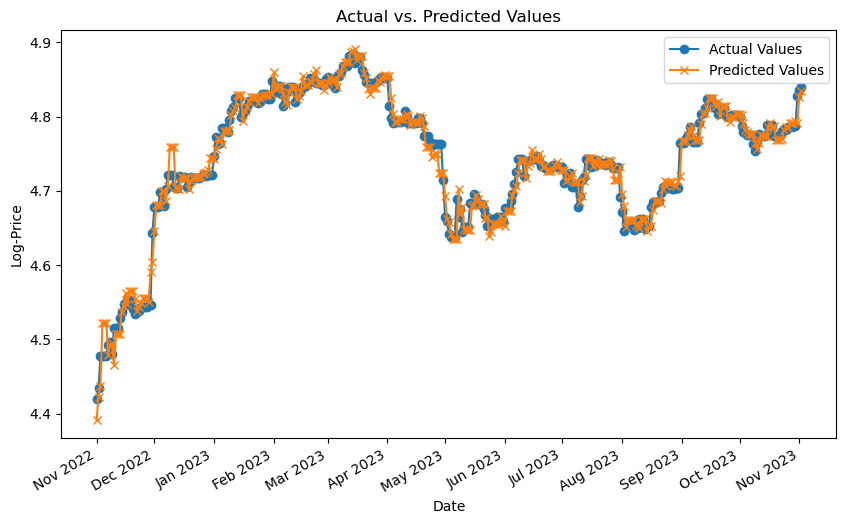

In [28]:
#Plotting final test results 

y_test_front_idx.index = pd.to_datetime(y_test_front_idx.index)

dates = y_test_front_idx.index
actual_values = y_test_front_idx['CLOSE_x']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_values, label='Actual Values', marker='o')
plt.plot(dates, y_pred_front_final, label='Predicted Values', marker='x')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.xlabel('Date')
plt.ylabel('Log-Price')
plt.title('Actual vs. Predicted Values')
plt.legend()  

plt.gcf().autofmt_xdate()

plt.show()

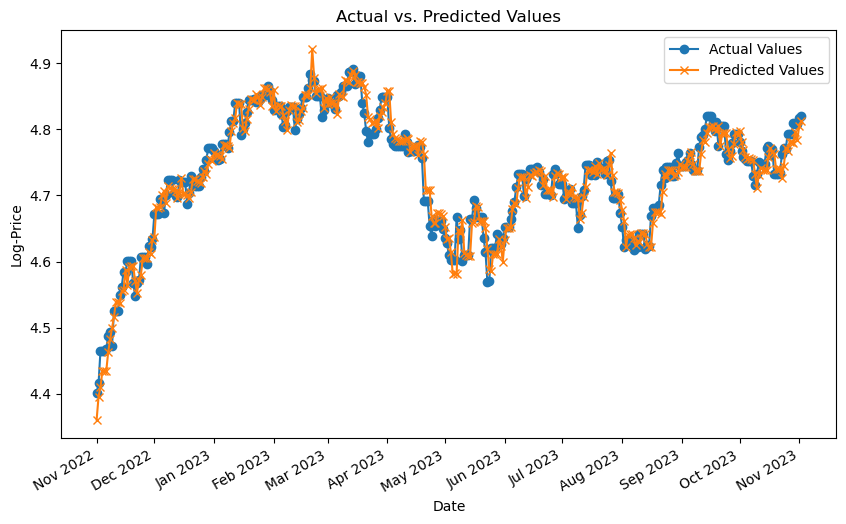

In [29]:
#Second-month

y_test_second_idx.index = pd.to_datetime(y_test_second_idx.index)

dates = y_test_second_idx.index
actual_values = y_test_second_idx['CLOSE_y']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_values, label='Actual Values', marker='o')
plt.plot(dates, y_pred_second_final, label='Predicted Values', marker='x')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.xlabel('Date')
plt.ylabel('Log-Price')
plt.title('Actual vs. Predicted Values')
plt.legend()  

plt.gcf().autofmt_xdate()

plt.show()

In [30]:
## Saving results for unrestricted models

#Stacked Regressor
train_stacked_reg_front_base_results.to_csv('train_stacked_reg_front_base_results.csv', index=False) #front-month
train_stacked_reg_front_results.to_csv('train_stacked_reg_front_results.csv', index=False)
stacked_reg_front_base_results.to_csv('stacked_reg_front_base_results.csv', index=False)
stacked_reg_front_results.to_csv('stacked_reg_front_results.csv', index=False)



train_stacked_reg_second_base_results.to_csv('train_stacked_reg_second_base_results.csv', index=False) #second-month
train_stacked_reg_second_results.to_csv('train_stacked_reg_second_results.csv', index=False)
stacked_reg_second_base_results.to_csv('stacked_reg_second_base_results.csv', index=False)
stacked_reg_second_results.to_csv('stacked_reg_second_results.csv', index=False)


#RERF


train_rerf_base_results_front.to_csv('train_rerf_base_results_front.csv', index=False) #front-month
train_rerf_results_front.to_csv('train_rerf_tuned_results_front.csv', index=False)
rerf_base_results_front.to_csv('rerf_base_results_front.csv', index=False)
rerf_results_front.to_csv('rerf_tuned_results_front.csv', index=False)

train_rerf_base_results_second.to_csv('train_rerf_base_results_second.csv', index=False) #second-month
train_rerf_results_second.to_csv('train_rerf_tuned_results_second.csv', index=False)
rerf_base_results_second.to_csv('rerf_base_results_second.csv', index=False)
rerf_results_second.to_csv('rerf_tuned_results_second.csv', index=False)

# Restricted Models <a class="anchor" id="restricted-models"></a>

In [31]:
# Loading restricted feature sets from JSON files
with open('front_month_restricted_features.json', 'r') as f:
    restricted_features_front = json.load(f)

with open('second_month_restricted_features.json', 'r') as f:
    restricted_features_second = json.load(f)

X_train_front_restricted = X_train_front[restricted_features_front]
X_test_front_restricted = X_test_front[restricted_features_front]
X_train_second_restricted = X_train_second[restricted_features_second]
X_test_second_restricted = X_test_second[restricted_features_second]

## Stacked Regressor <a class="anchor" id="stacked-reg-restricted"></a>

In [32]:
# Defining base models
base_models = [
    ('mlr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# Define the stacked regressor
stacked_regressor_front = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge() #Ridge as final estimator
)

stacked_regressor_second = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge()
)

# Fitting the stacked regressor on training data
stacked_regressor_front.fit(X_train_front_restricted, y_train_front)
stacked_regressor_second.fit(X_train_second_restricted, y_train_second)

StackingRegressor(estimators=[('mlr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge())

In [33]:
# Predictions on training set
y_train_pred_front_stacked = stacked_regressor_front.predict(X_train_front_restricted)
y_train_pred_second_stacked = stacked_regressor_second.predict(X_train_second_restricted)

# Predictions on  test set
y_test_pred_front_stacked = stacked_regressor_front.predict(X_test_front_restricted)
y_test_pred_second_stacked = stacked_regressor_second.predict(X_test_second_restricted)

# Evaluation of train and test 

# Front-month dataset
train_mae_front_stacked = mean_absolute_error(y_train_front, y_train_pred_front_stacked)
train_rmse_front_stacked = np.sqrt(mean_squared_error(y_train_front, y_train_pred_front_stacked))
train_mape_front_stacked = custom_mape(y_train_front, y_train_pred_front_stacked)
train_r2_front_stacked = r2_score(y_train_front, y_train_pred_front_stacked)
train_adj_r2_front_stacked = adjusted_r2(train_r2_front_stacked, len(y_train_front), X_train_front_restricted.shape[1])

test_mae_front_stacked = mean_absolute_error(y_test_front, y_test_pred_front_stacked)
test_rmse_front_stacked = np.sqrt(mean_squared_error(y_test_front, y_test_pred_front_stacked))
test_mape_front_stacked = custom_mape(y_test_front, y_test_pred_front_stacked)
test_r2_front_stacked = r2_score(y_test_front, y_test_pred_front_stacked)
test_adj_r2_front_stacked = adjusted_r2(test_r2_front_stacked, len(y_test_front), X_test_front_restricted.shape[1])

results_front_stacked_pre_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_mae_front_stacked, train_rmse_front_stacked, train_mape_front_stacked, train_r2_front_stacked, train_adj_r2_front_stacked],
    'Test': [test_mae_front_stacked, test_rmse_front_stacked, test_mape_front_stacked, test_r2_front_stacked, test_adj_r2_front_stacked]
}

# Second-month dataset
train_mae_second_stacked = mean_absolute_error(y_train_second, y_train_pred_second_stacked)
train_rmse_second_stacked = np.sqrt(mean_squared_error(y_train_second, y_train_pred_second_stacked))
train_mape_second_stacked = custom_mape(y_train_second, y_train_pred_second_stacked)
train_r2_second_stacked = r2_score(y_train_second, y_train_pred_second_stacked)
train_adj_r2_second_stacked = adjusted_r2(train_r2_second_stacked, len(y_train_second), X_train_second_restricted.shape[1])

test_mae_second_stacked = mean_absolute_error(y_test_second, y_test_pred_second_stacked)
test_rmse_second_stacked = np.sqrt(mean_squared_error(y_test_second, y_test_pred_second_stacked))
test_mape_second_stacked = custom_mape(y_test_second, y_test_pred_second_stacked)
test_r2_second_stacked = r2_score(y_test_second, y_test_pred_second_stacked)
test_adj_r2_second_stacked = adjusted_r2(test_r2_second_stacked, len(y_test_second), X_test_second_restricted.shape[1])

results_second_stacked_pre_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_mae_second_stacked, train_rmse_second_stacked, train_mape_second_stacked, train_r2_second_stacked, train_adj_r2_second_stacked],
    'Test': [test_mae_second_stacked, test_rmse_second_stacked, test_mape_second_stacked, test_r2_second_stacked, test_adj_r2_second_stacked]
}

# Converting results to dataframes
stacked_reg_results_front_pre_tuning = pd.DataFrame(results_front_stacked_pre_tuning)
stacked_reg_results_second_pre_tuning = pd.DataFrame(results_second_stacked_pre_tuning)

### Hyperparameter Tuning

In [34]:
# Defining a hyperparameter grid for the base models and final estimator
param_grid_stacked = {
    'mlr__fit_intercept': [True, False],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'final_estimator__alpha': [0.01, 0.1, 1.0],  # Ridge regularization parameter
    'final_estimator__fit_intercept': [True, False]
}

# Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with cross-validation
grid_search_front = GridSearchCV(stacked_regressor_front, param_grid_stacked, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_front.fit(X_train_front_restricted, y_train_front)

grid_search_second = GridSearchCV(stacked_regressor_second, param_grid_stacked, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_second.fit(X_train_second_restricted, y_train_second)

best_params_front = grid_search_front.best_params_
best_model_front = grid_search_front.best_estimator_

best_params_second = grid_search_second.best_params_
best_model_second = grid_search_second.best_estimator_

In [35]:
# Predictions on training set using the best model
y_train_pred_front_stacked_tuned = best_model_front.predict(X_train_front_restricted)
y_train_pred_second_stacked_tuned = best_model_second.predict(X_train_second_restricted)

# Predictions on test set using the best model
y_test_pred_front_stacked_tuned = best_model_front.predict(X_test_front_restricted)
y_test_pred_second_stacked_tuned = best_model_second.predict(X_test_second_restricted)

In [36]:
# Evaluation of Tuned Models

# Front-month dataset
train_mae_front_stacked_tuned = mean_absolute_error(y_train_front, y_train_pred_front_stacked_tuned)
train_rmse_front_stacked_tuned = np.sqrt(mean_squared_error(y_train_front, y_train_pred_front_stacked_tuned))
train_mape_front_stacked_tuned = custom_mape(y_train_front, y_train_pred_front_stacked_tuned)
train_r2_front_stacked_tuned = r2_score(y_train_front, y_train_pred_front_stacked_tuned)
train_adj_r2_front_stacked_tuned = adjusted_r2(train_r2_front_stacked_tuned, len(y_train_front), X_train_front_restricted.shape[1])



test_mae_front_stacked_tuned = mean_absolute_error(y_test_front, y_test_pred_front_stacked_tuned)
test_rmse_front_stacked_tuned = np.sqrt(mean_squared_error(y_test_front, y_test_pred_front_stacked_tuned))
test_mape_front_stacked_tuned = custom_mape(y_test_front, y_test_pred_front_stacked_tuned)
test_r2_front_stacked_tuned = r2_score(y_test_front, y_test_pred_front_stacked_tuned)
test_adj_r2_front_stacked_tuned = adjusted_r2(test_r2_front_stacked_tuned, len(y_test_front), X_test_front_restricted.shape[1])

results_front_stacked_post_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_mae_front_stacked_tuned, train_rmse_front_stacked_tuned, train_mape_front_stacked_tuned, train_r2_front_stacked_tuned, train_adj_r2_front_stacked_tuned],
    'Test': [test_mae_front_stacked_tuned, test_rmse_front_stacked_tuned, test_mape_front_stacked_tuned, test_r2_front_stacked_tuned, test_adj_r2_front_stacked_tuned]
}


# Second-month dataset
train_mae_second_stacked_tuned = mean_absolute_error(y_train_second, y_train_pred_second_stacked_tuned)
train_rmse_second_stacked_tuned = np.sqrt(mean_squared_error(y_train_second, y_train_pred_second_stacked_tuned))
train_mape_second_stacked_tuned = custom_mape(y_train_second, y_train_pred_second_stacked_tuned)
train_r2_second_stacked_tuned = r2_score(y_train_second, y_train_pred_second_stacked_tuned)
train_adj_r2_second_stacked_tuned = adjusted_r2(train_r2_second_stacked_tuned, len(y_train_second), X_train_second_restricted.shape[1])

test_mae_second_stacked_tuned = mean_absolute_error(y_test_second, y_test_pred_second_stacked_tuned)
test_rmse_second_stacked_tuned = np.sqrt(mean_squared_error(y_test_second, y_test_pred_second_stacked_tuned))
test_mape_second_stacked_tuned = custom_mape(y_test_second, y_test_pred_second_stacked_tuned)
test_r2_second_stacked_tuned = r2_score(y_test_second, y_test_pred_second_stacked_tuned)
test_adj_r2_second_stacked_tuned = adjusted_r2(test_r2_second_stacked_tuned, len(y_test_second), X_test_second_restricted.shape[1])

results_second_stacked_post_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_mae_second_stacked_tuned, train_rmse_second_stacked_tuned, train_mape_second_stacked_tuned, train_r2_second_stacked_tuned, train_adj_r2_second_stacked_tuned],
    'Test': [test_mae_second_stacked_tuned, test_rmse_second_stacked_tuned, test_mape_second_stacked_tuned, test_r2_second_stacked_tuned, test_adj_r2_second_stacked_tuned]
}

# Convert results to dataframes
stacked_reg_results_front_post_tuning = pd.DataFrame(results_front_stacked_post_tuning)
stacked_reg_results_second_post_tuning = pd.DataFrame(results_second_stacked_post_tuning)

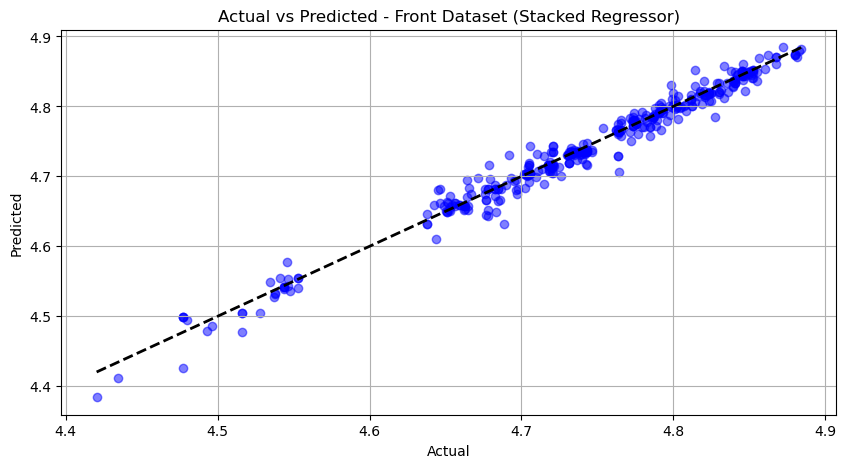

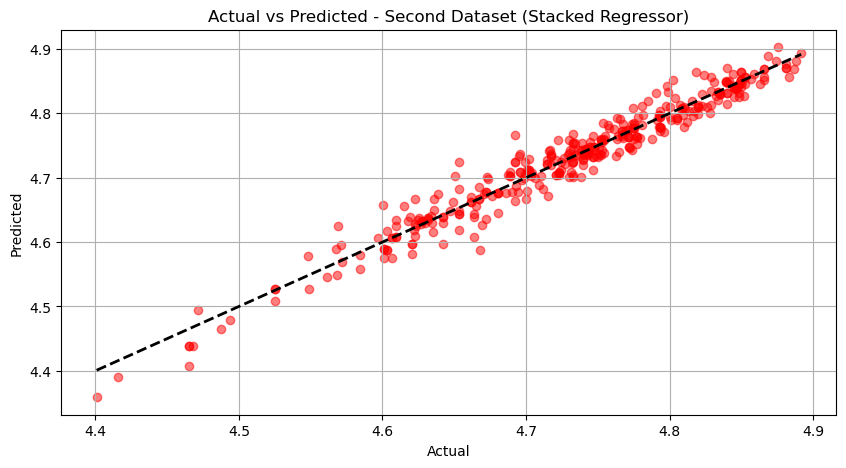

In [37]:
#Plotting Actuals vs. Predicted 

#Front-month
plt.figure(figsize=(10, 5))
plt.scatter(y_test_front, y_test_pred_front_stacked, color='blue', alpha=0.5)
plt.plot([y_test_front.min(), y_test_front.max()], [y_test_front.min(), y_test_front.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Front Dataset (Stacked Regressor)')
plt.grid(True)
plt.show()

#Second-month
plt.figure(figsize=(10, 5))
plt.scatter(y_test_second, y_test_pred_second_stacked, color='red', alpha=0.5)
plt.plot([y_test_second.min(), y_test_second.max()], [y_test_second.min(), y_test_second.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Second Dataset (Stacked Regressor)')
plt.grid(True)
plt.show()

In [38]:
# Save pre-tuning results for stacked regressor
stacked_reg_results_front_pre_tuning.to_csv('stacked_reg_results_front_pre_tuning.csv', index=False)
stacked_reg_results_second_pre_tuning.to_csv('stacked_reg_results_second_pre_tuning.csv', index=False)

# Save post-tuning results for stacked regressor
stacked_reg_results_front_post_tuning.to_csv('stacked_reg_results_front_post_tuning.csv', index=False)
stacked_reg_results_second_post_tuning.to_csv('stacked_reg_results_second_post_tuning.csv', index=False)

## Regression-Enhanced Random Forest  <a class="anchor" id="rerf-restricted"></a>

In [39]:
# Initialize and fitting the linear regression model
lr_front = LinearRegression()
lr_front.fit(X_train_front_restricted, y_train_front)

lr_second = LinearRegression()
lr_second.fit(X_train_second_restricted, y_train_second)

# Lin reg predictions
y_train_front_pred_lr = lr_front.predict(X_train_front_restricted)
y_test_front_pred_lr = lr_front.predict(X_test_front_restricted)

y_train_second_pred_lr = lr_second.predict(X_train_second_restricted)
y_test_second_pred_lr = lr_second.predict(X_test_second_restricted)

# Calculating residuals on training
lr_residuals_train_front = y_train_front - y_train_front_pred_lr
lr_residuals_train_second = y_train_second - y_train_second_pred_lr

# Initializing and fitting the Random Forest model
rf_front = RandomForestRegressor(random_state=42)
rf_front.fit(X_train_front_restricted, lr_residuals_train_front)

rf_second = RandomForestRegressor(random_state=42)
rf_second.fit(X_train_second_restricted, lr_residuals_train_second)

RandomForestRegressor(random_state=42)

In [40]:
rf_predictions_residuals_train_front = rf_front.predict(X_train_front_restricted)

# Pre-tuning training predictions
combined_predictions_train_front = y_train_front_pred_lr + rf_predictions_residuals_train_front

rf_predictions_residuals_train_second = rf_second.predict(X_train_second_restricted)

# Pre-tuning training predictions
combined_predictions_train_second = y_train_second_pred_lr + rf_predictions_residuals_train_second

# Pre-tuning train evaluation
train_rerf_mae_front = mean_absolute_error(y_train_front, combined_predictions_train_front)
train_rerf_rmse_front = np.sqrt(mean_squared_error(y_train_front, combined_predictions_train_front))
train_rerf_mape_front = custom_mape(y_train_front, combined_predictions_train_front)
train_rerf_r2_front = r2_score(y_train_front, combined_predictions_train_front)
train_rerf_adj_r2_front = adjusted_r2(train_rerf_r2_front, len(y_train_front), X_train_front_restricted.shape[1])

train_rerf_mae_second = mean_absolute_error(y_train_second, combined_predictions_train_second)
train_rerf_rmse_second = np.sqrt(mean_squared_error(y_train_second, combined_predictions_train_second))
train_rerf_mape_second = custom_mape(y_train_second, combined_predictions_train_second)
train_rerf_r2_second = r2_score(y_train_second, combined_predictions_train_second)
train_rerf_adj_r2_second = adjusted_r2(train_rerf_r2_second, len(y_train_second), X_train_second_restricted.shape[1])

rf_predictions_residuals_test_front = rf_front.predict(X_test_front_restricted)

# Pre-tuning test predictions
combined_predictions_test_front = y_test_front_pred_lr + rf_predictions_residuals_test_front

rf_predictions_residuals_test_second = rf_second.predict(X_test_second_restricted)

# Pre-tuning test predictions
combined_predictions_test_second = y_test_second_pred_lr + rf_predictions_residuals_test_second

#Pre-tuning test evaluation
test_rerf_mae_front = mean_absolute_error(y_test_front, combined_predictions_test_front)
test_rerf_rmse_front = np.sqrt(mean_squared_error(y_test_front, combined_predictions_test_front))
test_rerf_mape_front = custom_mape(y_test_front, combined_predictions_test_front)
test_rerf_r2_front = r2_score(y_test_front, combined_predictions_test_front)
test_rerf_adj_r2_front = adjusted_r2(test_rerf_r2_front, len(y_test_front), X_test_front_restricted.shape[1])

test_rerf_mae_second = mean_absolute_error(y_test_second, combined_predictions_test_second)
test_rerf_rmse_second = np.sqrt(mean_squared_error(y_test_second, combined_predictions_test_second))
test_rerf_mape_second = custom_mape(y_test_second, combined_predictions_test_second)
test_rerf_r2_second = r2_score(y_test_second, combined_predictions_test_second)
test_rerf_adj_r2_second = adjusted_r2(test_rerf_r2_second, len(y_test_second), X_test_second_restricted.shape[1])

results_front_rerf_pre_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_rerf_mae_front, train_rerf_rmse_front, train_rerf_mape_front, train_rerf_r2_front, train_rerf_adj_r2_front],
    'Test': [test_rerf_mae_front, test_rerf_rmse_front, test_rerf_mape_front, test_rerf_r2_front, test_rerf_adj_r2_front]
}

results_second_rerf_pre_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_rerf_mae_second, train_rerf_rmse_second, train_rerf_mape_second, train_rerf_r2_second, train_rerf_adj_r2_second],
    'Test': [test_rerf_mae_second, test_rerf_rmse_second, test_rerf_mape_second, test_rerf_r2_second, test_rerf_adj_r2_second]
}

#Converting results to dataframes
rerf_results_front_pre_tuning = pd.DataFrame(results_front_rerf_pre_tuning)
rerf_results_second_pre_tuning = pd.DataFrame(results_second_rerf_pre_tuning)

### Hyperparameter Tuning

In [41]:
# Defining the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing TS cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with cross-validation for Random Forest on residuals
grid_search_rf_front = GridSearchCV(rf_front, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf_front.fit(X_train_front_restricted, lr_residuals_train_front)

grid_search_rf_second = GridSearchCV(rf_second, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf_second.fit(X_train_second_restricted, lr_residuals_train_second)

best_rf_front_restricted = grid_search_rf_front.best_estimator_
best_rf_second_restricted = grid_search_rf_second.best_estimator_

In [42]:
# Predicting on the train set using tuned RF
rf_predictions_residuals_train_front_tuned = best_rf_front_restricted.predict(X_train_front_restricted)
combined_predictions_train_front_tuned = y_train_front_pred_lr + rf_predictions_residuals_train_front_tuned

rf_predictions_residuals_train_second_tuned = best_rf_second_restricted.predict(X_train_second_restricted)
combined_predictions_train_second_tuned = y_train_second_pred_lr + rf_predictions_residuals_train_second_tuned

# Predicting on the test set using tuned RF
rf_predictions_residuals_test_front_tuned = best_rf_front_restricted.predict(X_test_front_restricted)
combined_predictions_test_front_tuned = y_test_front_pred_lr + rf_predictions_residuals_test_front_tuned

rf_predictions_residuals_test_second_tuned = best_rf_second_restricted.predict(X_test_second_restricted)
combined_predictions_test_second_tuned = y_test_second_pred_lr + rf_predictions_residuals_test_second_tuned

# Train eval of tuned model
train_rerf_mae_front_tuned = mean_absolute_error(y_train_front, combined_predictions_train_front_tuned)
train_rerf_rmse_front_tuned = np.sqrt(mean_squared_error(y_train_front, combined_predictions_train_front_tuned))
train_rerf_mape_front_tuned = custom_mape(y_train_front, combined_predictions_train_front_tuned)
train_rerf_r2_front_tuned = r2_score(y_train_front, combined_predictions_train_front_tuned)
train_rerf_adj_r2_front_tuned = adjusted_r2(train_rerf_r2_front_tuned, len(y_train_front), X_train_front_restricted.shape[1])

train_rerf_mae_second_tuned = mean_absolute_error(y_train_second, combined_predictions_train_second_tuned)
train_rerf_rmse_second_tuned = np.sqrt(mean_squared_error(y_train_second, combined_predictions_train_second_tuned))
train_rerf_mape_second_tuned = custom_mape(y_train_second, combined_predictions_train_second_tuned)
train_rerf_r2_second_tuned = r2_score(y_train_second, combined_predictions_train_second_tuned)
train_rerf_adj_r2_second_tuned = adjusted_r2(train_rerf_r2_second_tuned, len(y_train_second), X_train_second_restricted.shape[1])

# Test eval of tuned model
test_rerf_mae_front_tuned = mean_absolute_error(y_test_front, combined_predictions_test_front_tuned)
test_rerf_rmse_front_tuned = np.sqrt(mean_squared_error(y_test_front, combined_predictions_test_front_tuned))
test_rerf_mape_front_tuned = custom_mape(y_test_front, combined_predictions_test_front_tuned)
test_rerf_r2_front_tuned = r2_score(y_test_front, combined_predictions_test_front_tuned)
test_rerf_adj_r2_front_tuned = adjusted_r2(test_rerf_r2_front_tuned, len(y_test_front), X_test_front_restricted.shape[1])

test_rerf_mae_second_tuned = mean_absolute_error(y_test_second, combined_predictions_test_second_tuned)
test_rerf_rmse_second_tuned = np.sqrt(mean_squared_error(y_test_second, combined_predictions_test_second_tuned))
test_rerf_mape_second_tuned = custom_mape(y_test_second, combined_predictions_test_second_tuned)
test_rerf_r2_second_tuned = r2_score(y_test_second, combined_predictions_test_second_tuned)
test_rerf_adj_r2_second_tuned = adjusted_r2(test_rerf_r2_second_tuned, len(y_test_second), X_test_second_restricted.shape[1])

results_front_rerf_post_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_rerf_mae_front_tuned, train_rerf_rmse_front_tuned, train_rerf_mape_front_tuned, train_rerf_r2_front_tuned, train_rerf_adj_r2_front_tuned],
    'Test': [test_rerf_mae_front_tuned, test_rerf_rmse_front_tuned, test_rerf_mape_front_tuned, test_rerf_r2_front_tuned, test_rerf_adj_r2_front_tuned]
}

results_second_rerf_post_tuning = {
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Adjusted R-squared'],
    'Train': [train_rerf_mae_second_tuned, train_rerf_rmse_second_tuned, train_rerf_mape_second_tuned, train_rerf_r2_second_tuned, train_rerf_adj_r2_second_tuned],
    'Test': [test_rerf_mae_second_tuned, test_rerf_rmse_second_tuned, test_rerf_mape_second_tuned, test_rerf_r2_second_tuned, test_rerf_adj_r2_second_tuned]
}

# Converting results to dataframes
rerf_results_front_post_tuning = pd.DataFrame(results_front_rerf_post_tuning)
rerf_results_second_post_tuning = pd.DataFrame(results_second_rerf_post_tuning)

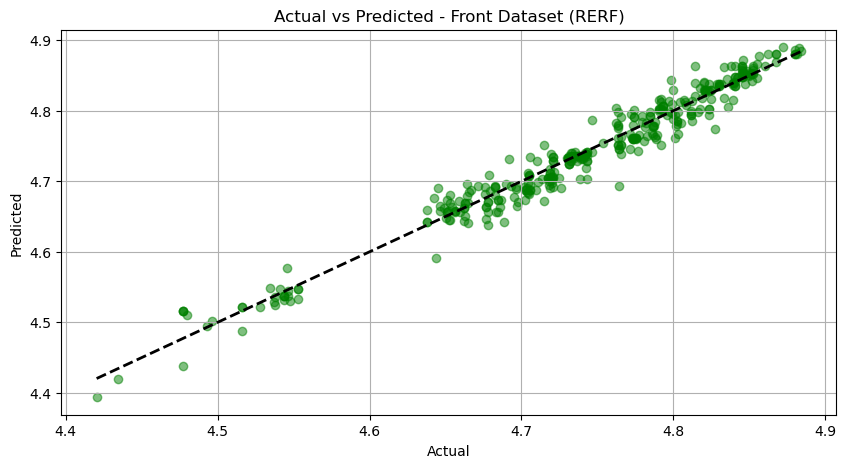

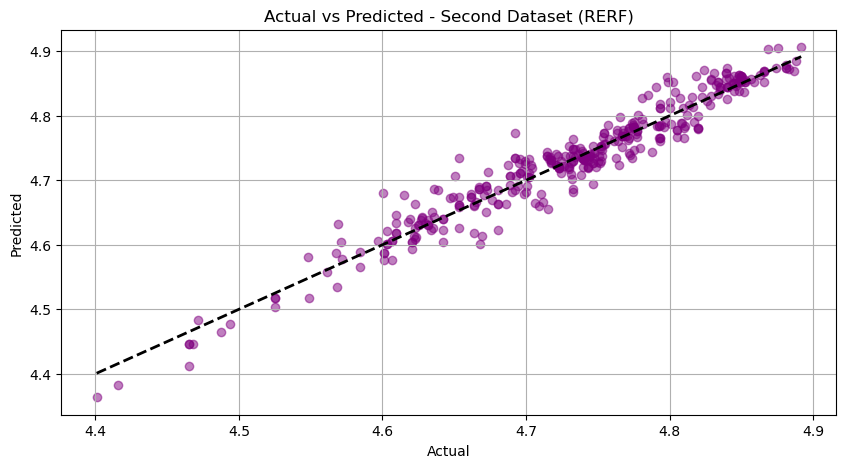

In [43]:
#Plotting Actual vs. Predicted 

#Front-month
plt.figure(figsize=(10, 5))
plt.scatter(y_test_front, combined_predictions_test_front, color='green', alpha=0.5)
plt.plot([y_test_front.min(), y_test_front.max()], [y_test_front.min(), y_test_front.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Front Dataset (RERF)')
plt.grid(True)
plt.show()

#Second-month 
plt.figure(figsize=(10, 5))
plt.scatter(y_test_second, combined_predictions_test_second, color='purple', alpha=0.5)
plt.plot([y_test_second.min(), y_test_second.max()], [y_test_second.min(), y_test_second.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Second Dataset (RERF)')
plt.grid(True)
plt.show()

In [44]:
# Save pre-tuning results
rerf_results_front_pre_tuning.to_csv('rerf_results_front_pre_tuning.csv', index=False)
rerf_results_second_pre_tuning.to_csv('rerf_results_second_pre_tuning.csv', index=False)

# Save post-tuning results
rerf_results_front_post_tuning.to_csv('rerf_results_front_post_tuning.csv', index=False)
rerf_results_second_post_tuning.to_csv('rerf_results_second_post_tuning.csv', index=False)